# Data Imports

In [2]:
import requests
import pandas as pd
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [ ]:
# Step 1: Get bootstrap data (teams, players)
bootstrap_url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
bootstrap_data = requests.get(bootstrap_url).json()

players_df = pd.DataFrame(bootstrap_data['elements'])
teams_df = pd.DataFrame(bootstrap_data['teams'])

# Step 2: Get all fixtures separately
fixtures_url = 'https://fantasy.premierleague.com/api/fixtures/'
all_fixtures = pd.DataFrame(requests.get(fixtures_url).json())

# Step 3: Get player histories with team context
all_player_histories = []

for player_id in players_df['id']:
    try:
        url = f'https://fantasy.premierleague.com/api/element-summary/{player_id}/'
        response = requests.get(url)
        player_data = response.json()
        
        # Get history
        history = pd.DataFrame(player_data['history'])
        if len(history) == 0:
            continue
            
        history['player_id'] = player_id
        all_player_histories.append(history)
        
        time.sleep(0.1)  # Be nice to the API
        
        # Print progress every 50 players
        if player_id % 50 == 0:
            print(f"Processed {player_id} players...")
        
    except Exception as e:
        print(f"Error with player {player_id}: {e}")
        continue

print(f"Finished collecting data for {len(all_player_histories)} players")

# Combine all histories
history_df = pd.concat(all_player_histories, ignore_index=True)

# IMPORTANT: Convert numeric columns to proper types
numeric_cols = ['total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
                'goals_conceded', 'saves', 'bonus', 'bps', 'yellow_cards', 'red_cards',
                'own_goals', 'penalties_saved', 'penalties_missed',
                'expected_goals', 'expected_assists', 'expected_goal_involvements',
                'expected_goals_conceded', 'influence', 'creativity', 'threat', 
                'ict_index', 'tackles', 'clearances_blocks_interceptions', 'recoveries',
                'selected', 'transfers_in', 'transfers_out', 'transfers_balance', 'value']

for col in numeric_cols:
    if col in history_df.columns:
        history_df[col] = pd.to_numeric(history_df[col], errors='coerce')

# Step 4: Add player info (name, team, position)
history_df = history_df.merge(
    players_df[['id', 'web_name', 'team', 'element_type', 'now_cost']], 
    left_on='player_id', 
    right_on='id',
    how='left'
)

# Step 4b: Add readable position names
# FPL position codes: 1=GK, 2=DEF, 3=MID, 4=FWD
position_map = {
    1: 'GK',
    2: 'DEF',
    3: 'MID',
    4: 'FWD'
}
history_df['position'] = history_df['element_type'].map(position_map)

# Step 5: Add player's team name and info
history_df = history_df.merge(
    teams_df[['id', 'name', 'short_name', 'strength', 'strength_overall_home', 
              'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
              'strength_defence_home', 'strength_defence_away']],
    left_on='team',
    right_on='id',
    how='left',
    suffixes=('', '_team_info')
)

# Step 6: Add opponent team info
history_df = history_df.merge(
    teams_df[['id', 'name', 'short_name', 'strength', 'strength_overall_home', 
              'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
              'strength_defence_home', 'strength_defence_away']],
    left_on='opponent_team',
    right_on='id',
    how='left',
    suffixes=('_player_team', '_opponent')
)

# Step 7: Calculate rolling stats (last 3, 5 gameweeks)
history_df = history_df.sort_values(['player_id', 'round'])

# Rolling points
history_df['points_last_3gw'] = history_df.groupby('player_id')['total_points'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
history_df['points_last_5gw'] = history_df.groupby('player_id')['total_points'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
)

# Rolling minutes (to predict playing time)
history_df['minutes_last_3gw'] = history_df.groupby('player_id')['minutes'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling goals
history_df['goals_last_3gw'] = history_df.groupby('player_id')['goals_scored'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling assists
history_df['assists_last_3gw'] = history_df.groupby('player_id')['assists'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling xG (expected goals)
history_df['xg_last_3gw'] = history_df.groupby('player_id')['expected_goals'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling xA (expected assists)
history_df['xa_last_3gw'] = history_df.groupby('player_id')['expected_assists'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling xGI (expected goal involvements)
history_df['xgi_last_3gw'] = history_df.groupby('player_id')['expected_goal_involvements'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Rolling clean sheets (for defenders/keepers)
history_df['clean_sheets_last_3gw'] = history_df.groupby('player_id')['clean_sheets'].transform(
    lambda x: x.rolling(window=3, min_periods=1).sum()
)

# Rolling bonus points
history_df['bonus_last_3gw'] = history_df.groupby('player_id')['bonus'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Step 8: Add team form (team's average points in last few games)
team_points_by_gw = history_df.groupby(['team', 'round'])['total_points'].sum().reset_index()
team_points_by_gw.columns = ['team', 'round', 'team_total_points']

team_points_by_gw = team_points_by_gw.sort_values(['team', 'round'])
team_points_by_gw['team_form_last_3gw'] = team_points_by_gw.groupby('team')['team_total_points'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Merge team form back
history_df = history_df.merge(
    team_points_by_gw[['team', 'round', 'team_form_last_3gw']],
    on=['team', 'round'],
    how='left'
)

# Step 9: Add fixture difficulty from opponent strength
history_df['fixture_difficulty'] = history_df.apply(
    lambda row: row['strength_defence_home_opponent'] if row['was_home'] 
    else row['strength_defence_away_opponent'],
    axis=1
)

# Step 10: Calculate performance metrics
# Goals vs expected goals (overperformance/underperformance)
history_df['goals_vs_xg'] = history_df['goals_scored'] - history_df['expected_goals']

# Assists vs expected assists
history_df['assists_vs_xa'] = history_df['assists'] - history_df['expected_assists']

# ICT index per 90 minutes (to normalize for playing time)
history_df['ict_per_90'] = history_df.apply(
    lambda row: (row['ict_index'] / row['minutes'] * 90) if row['minutes'] > 0 else 0,
    axis=1
)

# Step 11: Clean up column names
history_df = history_df.rename(columns={
    'web_name': 'player_name',
    'round': 'gameweek',
    'name_player_team': 'team_name',
    'short_name_player_team': 'team_short',
    'name_opponent': 'opponent_name',
    'short_name_opponent': 'opponent_short',
    'total_points': 'points'
})

# Step 12: Select comprehensive columns for your model
final_df = history_df[[
    # Identifiers
    'player_id', 'player_name', 'position', 'element_type', 'gameweek', 'fixture',
    
    # Match context
    'team_name', 'team_short', 'opponent_name', 'opponent_short', 'was_home',
    
    # Core performance stats (actual)
    'points', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'bonus',
    'goals_conceded', 'saves', 'yellow_cards', 'red_cards',
    'own_goals', 'penalties_saved', 'penalties_missed',
    
    # Expected stats (underlying metrics)
    'expected_goals', 'expected_assists', 'expected_goal_involvements',
    'expected_goals_conceded',
    
    # Advanced metrics
    'influence', 'creativity', 'threat', 'ict_index',
    'bps',  # bonus point system
    'tackles', 'clearances_blocks_interceptions', 'recoveries',
    
    # Performance vs expectation
    'goals_vs_xg', 'assists_vs_xa', 'ict_per_90',
    
    # Rolling form (last 3 gameweeks)
    'points_last_3gw', 'points_last_5gw',
    'minutes_last_3gw', 
    'goals_last_3gw', 'assists_last_3gw',
    'xg_last_3gw', 'xa_last_3gw', 'xgi_last_3gw',
    'clean_sheets_last_3gw', 'bonus_last_3gw',
    
    # Team context
    'team_form_last_3gw',
    
    # Fixture difficulty
    'fixture_difficulty',
    'strength_overall_home_player_team', 'strength_overall_away_player_team',
    'strength_attack_home_player_team', 'strength_attack_away_player_team',
    'strength_defence_home_opponent', 'strength_defence_away_opponent',
    
    # Player info
    'now_cost',
    
    # Transfer data (popularity/ownership signals)
    'selected', 'transfers_in', 'transfers_out', 'transfers_balance'
]]

# Save it!
final_df.to_csv('fpl_enriched_history.csv', index=False)

Processed 700 players...
Processed 50 players...
Processed 200 players...
Processed 100 players...
Processed 150 players...
Processed 250 players...
Processed 300 players...
Processed 350 players...
Processed 400 players...
Processed 450 players...
Processed 500 players...
Processed 550 players...
Processed 600 players...
Processed 650 players...
Finished collecting data for 743 players

Total records: 5073

Position breakdown:
position
MID    2257
DEF    1677
GK      589
FWD     550
Name: count, dtype: int64

Sample of the data:
   player_id   player_name position  element_type  gameweek  fixture  \
0          1          Raya       GK             1         1        9   
1          1          Raya       GK             1         2       11   
2          1          Raya       GK             1         3       25   
3          1          Raya       GK             1         4       31   
4          1          Raya       GK             1         5       41   
5          1          Raya      

# Loading and Formatting data to prevent future peeking

In [3]:
# Load your enriched history data
df = pd.read_csv('fpl_enriched_history.csv')

# Sort by player and gameweek to ensure proper ordering
df = df.sort_values(['player_id', 'gameweek'])

# ==============================================================
# STEP 1: Create features that look BACKWARD (no future peeking)
# ==============================================================

# The target we want to predict (next gameweek's points)
df['target_points'] = df.groupby('player_id')['points'].shift(-1)

# Lag all current gameweek stats by 1 (so we're using past performance only)
lag_features = ['points', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
                'bonus', 'expected_goals', 'expected_assists', 
                'expected_goal_involvements', 'ict_index', 'bps']

for feature in lag_features:
    df[f'{feature}_lag1'] = df.groupby('player_id')[feature].shift(1)

# ==============================================================
# STEP 2: Recalculate rolling averages EXCLUDING current gameweek
# ==============================================================

# Rolling averages over last 3 gameweeks (excluding current)
df['points_last_3gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['points_last_5gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

df['minutes_last_3gw'] = df.groupby('player_id')['minutes'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['goals_last_3gw'] = df.groupby('player_id')['goals_scored'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['assists_last_3gw'] = df.groupby('player_id')['assists'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['xg_last_3gw'] = df.groupby('player_id')['expected_goals'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['xa_last_3gw'] = df.groupby('player_id')['expected_assists'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['xgi_last_3gw'] = df.groupby('player_id')['expected_goal_involvements'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['clean_sheets_last_3gw'] = df.groupby('player_id')['clean_sheets'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()
)

df['bonus_last_3gw'] = df.groupby('player_id')['bonus'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

df['ict_last_3gw'] = df.groupby('player_id')['ict_index'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

# ==============================================================
# STEP 3: Create additional useful features
# ==============================================================

# Minutes played percentage (are they nailed on starters?)
df['minutes_percentage_last_3'] = (df['minutes_last_3gw'] / 90) * 100

# Goals per 90 minutes (efficiency metric)
df['goals_per_90'] = df.apply(
    lambda row: (row['goals_last_3gw'] / row['minutes_last_3gw'] * 90) 
    if row['minutes_last_3gw'] > 0 else 0,
    axis=1
)

# Consistency (standard deviation of points)
df['points_std_last_5gw'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=2).std()
)

# Trend: is player's form improving or declining?
df['points_trend'] = df.groupby('player_id')['points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=2).apply(
        lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) >= 2 else 0
    )
)

# ==============================================================
# STEP 4: Get FUTURE fixture information (this is allowed!)
# ==============================================================
# We need to know who they're playing NEXT gameweek for predictions

# Shift opponent info forward (next opponent)
df['next_opponent'] = df.groupby('player_id')['opponent_name'].shift(-1)
df['next_was_home'] = df.groupby('player_id')['was_home'].shift(-1)
df['next_fixture_difficulty'] = df.groupby('player_id')['fixture_difficulty'].shift(-1)

# Opponent's defensive strength for NEXT match
df['next_opp_def_strength'] = df.groupby('player_id')['strength_defence_home_opponent'].shift(-1)

# ==============================================================
# STEP 5: Remove rows we can't use
# ==============================================================

# Drop first gameweek for each player (no historical data)
# Drop last gameweek for each player (no target to predict)
df = df.dropna(subset=['target_points', 'points_last_3gw'])

# ==============================================================
# STEP 6: Select features for modeling
# ==============================================================

feature_columns = [
    # Player characteristics
    'position', 'now_cost',
    
    # Recent form (properly lagged)
    'points_last_3gw', 'points_last_5gw',
    'minutes_last_3gw', 'minutes_percentage_last_3',
    'goals_last_3gw', 'assists_last_3gw',
    'xg_last_3gw', 'xa_last_3gw', 'xgi_last_3gw',
    'clean_sheets_last_3gw', 'bonus_last_3gw',
    'ict_last_3gw',
    
    # Performance metrics
    'goals_per_90',
    'points_std_last_5gw',  # consistency
    'points_trend',  # improving or declining
    
    # Next match context (future info - allowed!)
    'next_was_home',
    'next_fixture_difficulty',
    'next_opp_def_strength',
    
    # Team strength
    'strength_attack_home_player_team',
    'strength_attack_away_player_team',
    
    # Popularity (can indicate insider info)
    'transfers_balance',
]

target_column = 'target_points'

# Create final modeling dataset
model_df = df[feature_columns + [target_column] + ['player_id', 'player_name', 'gameweek']].copy()

# Handle any remaining NaNs
model_df = model_df.fillna(0)

# Save the properly formatted data
model_df.to_csv('fpl_modeling_data.csv', index=False)

print(f"Modeling dataset created: {len(model_df)} rows")
print(f"\nFeature columns ({len(feature_columns)}):")
print(feature_columns)
print(f"\nSample data:")
print(model_df.head(10))
print(f"\nTarget distribution:")
print(model_df['target_points'].describe())

Modeling dataset created: 3588 rows

Feature columns (23):
['position', 'now_cost', 'points_last_3gw', 'points_last_5gw', 'minutes_last_3gw', 'minutes_percentage_last_3', 'goals_last_3gw', 'assists_last_3gw', 'xg_last_3gw', 'xa_last_3gw', 'xgi_last_3gw', 'clean_sheets_last_3gw', 'bonus_last_3gw', 'ict_last_3gw', 'goals_per_90', 'points_std_last_5gw', 'points_trend', 'next_was_home', 'next_fixture_difficulty', 'next_opp_def_strength', 'strength_attack_home_player_team', 'strength_attack_away_player_team', 'transfers_balance']

Sample data:
   position  now_cost  points_last_3gw  ...  player_id   player_name  gameweek
1        GK        57        10.000000  ...          1          Raya         2
2        GK        57         8.000000  ...          1          Raya         3
3        GK        57         6.000000  ...          1          Raya         4
4        GK        57         4.666667  ...          1          Raya         5
5        GK        57         3.333333  ...          1      

C:\Users\Pisit Tangwongsiri\AppData\Local\Temp\ipykernel_10408\169844623.py:158: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_df = model_df.fillna(0)


# Checking for Collinearity

VARIANCE INFLATION FACTOR (VIF) ANALYSIS
VIF > 10: High multicollinearity
VIF > 5: Moderate multicollinearity
VIF < 5: Low multicollinearity



c:\Users\Pisit Tangwongsiri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                          Feature          VIF
                     goals_scored          inf
                          assists          inf
                     transfers_in          inf
                transfers_balance          inf
                    transfers_out          inf
                 minutes_last_3gw          inf
                      goals_vs_xg          inf
                    assists_vs_xa          inf
                 expected_assists          inf
                   expected_goals          inf
        minutes_percentage_last_3          inf
                     xgi_last_3gw 3.516682e+06
                      xg_last_3gw 2.200646e+06
  expected_goal_involvements_lag1 1.258032e+06
              expected_goals_lag1 8.229557e+05
                      xa_last_3gw 5.481742e+05
       expected_goal_involvements 3.407506e+05
            expected_assists_lag1 2.332059e+05
strength_overall_home_player_team 6.092297e+03
                        ict_index 5.865052e+03
 strength_att

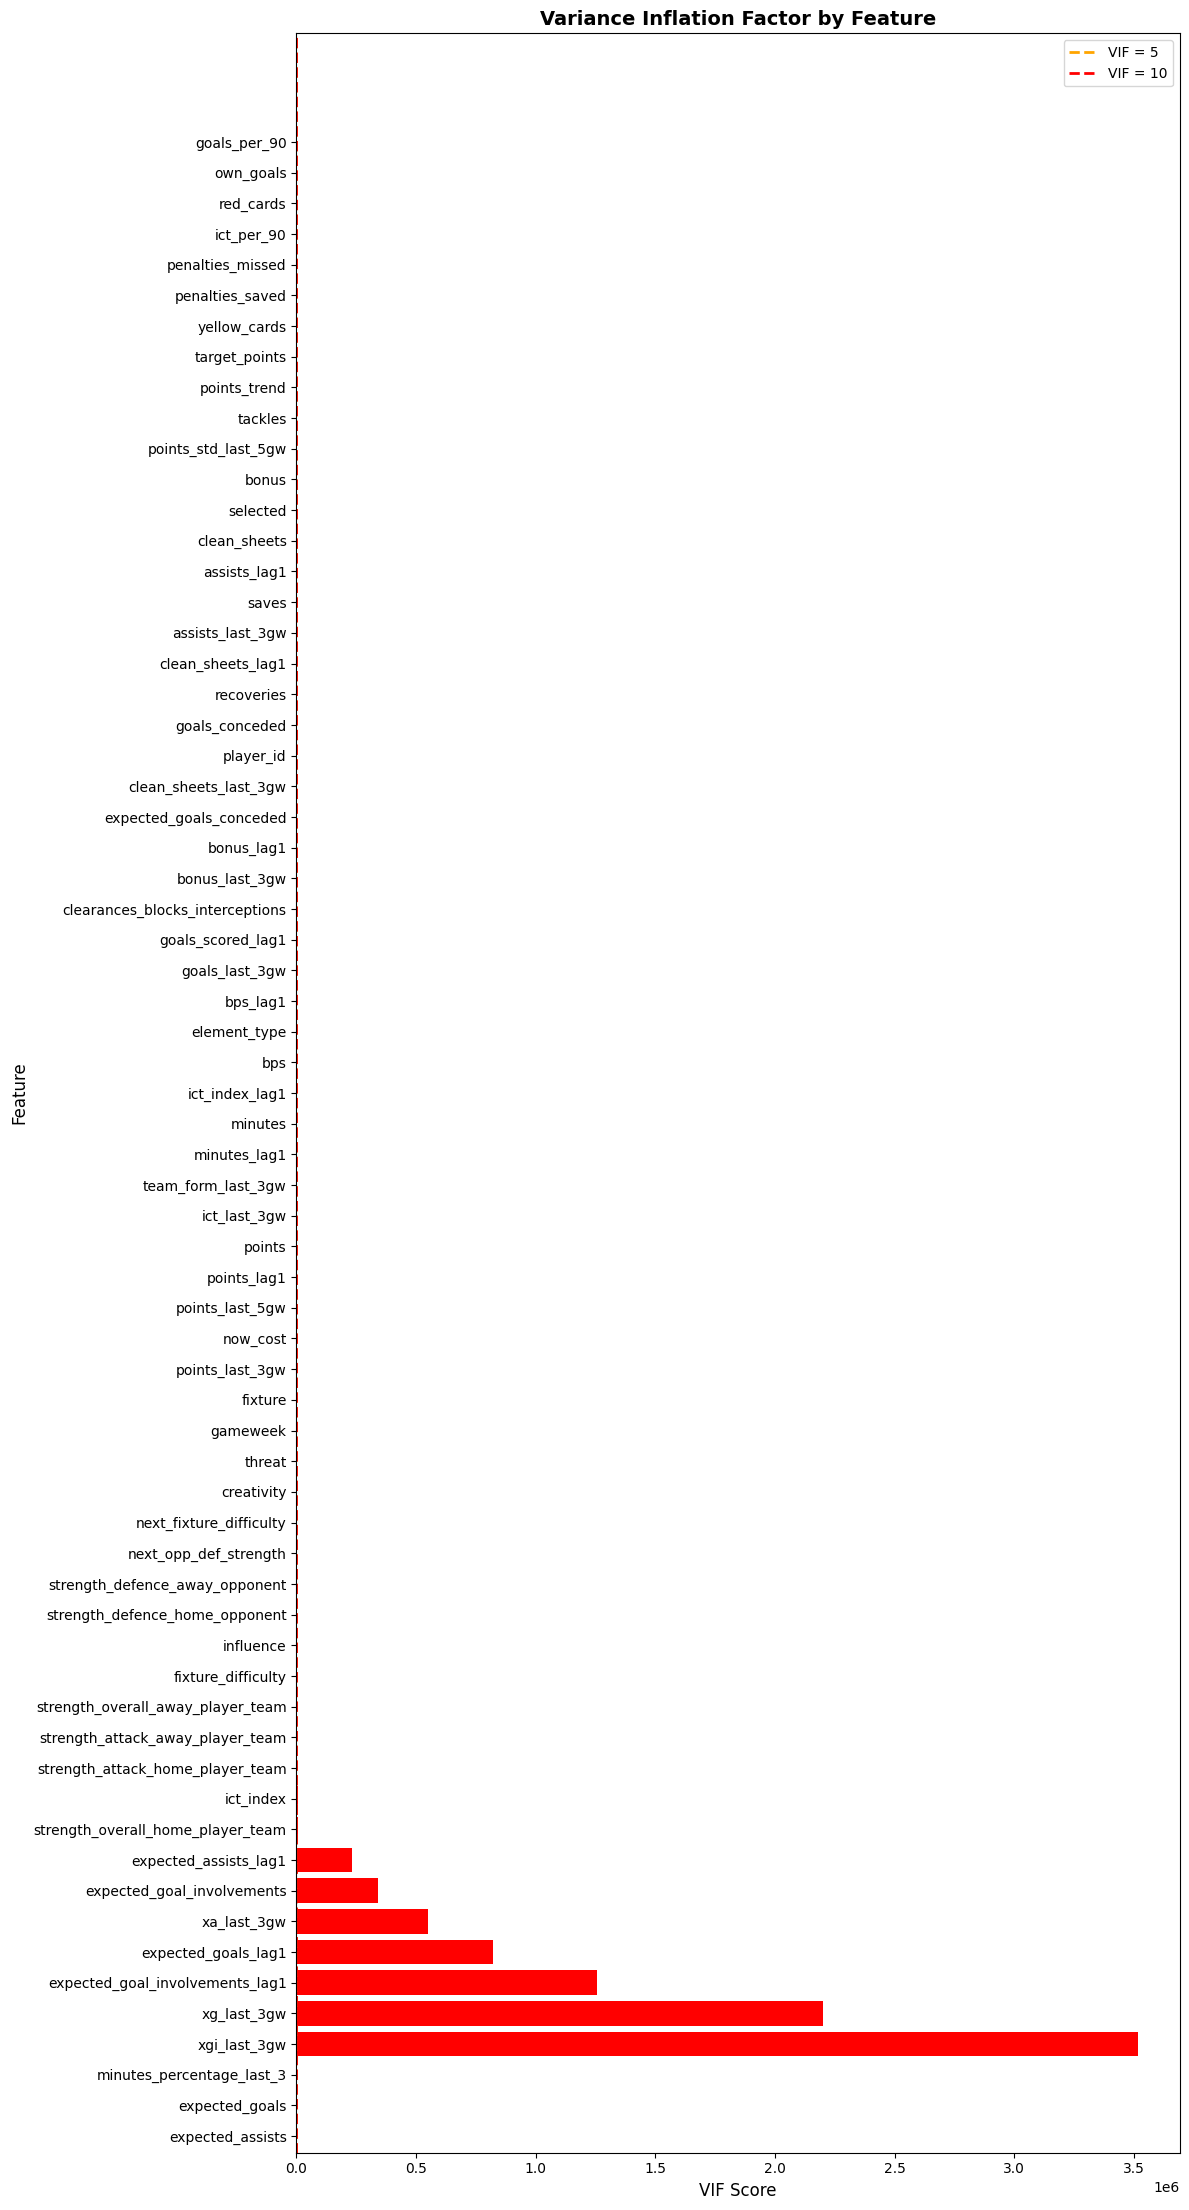


📊 VIF chart saved as 'vif_scores.png'

RECOMMENDATIONS

🔧 Features to consider removing (VIF > 10):
   - goals_scored
   - assists
   - transfers_in
   - transfers_balance
   - transfers_out
   - minutes_last_3gw
   - goals_vs_xg
   - assists_vs_xa
   - expected_assists
   - expected_goals
   - minutes_percentage_last_3
   - xgi_last_3gw
   - xg_last_3gw
   - expected_goal_involvements_lag1
   - expected_goals_lag1
   - xa_last_3gw
   - expected_goal_involvements
   - expected_assists_lag1
   - strength_overall_home_player_team
   - ict_index
   - strength_attack_home_player_team
   - strength_attack_away_player_team
   - strength_overall_away_player_team
   - fixture_difficulty
   - influence
   - strength_defence_home_opponent
   - strength_defence_away_opponent
   - next_opp_def_strength
   - next_fixture_difficulty
   - creativity
   - threat
   - gameweek
   - fixture
   - points_last_3gw
   - now_cost
   - points_last_5gw
   - points_lag1
   - points
   - ict_last_3gw
   - team_

In [5]:
def check_vif(df, feature_columns, save_plot=True):
    """
    Calculate Variance Inflation Factor (VIF) for all features.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Your modeling dataframe
    feature_columns : list
        List of feature column names to check
    save_plot : bool
        Whether to save visualization (default True)
    
    Returns:
    --------
    pandas DataFrame : VIF scores for each feature
    """
    
    print("=" * 60)
    print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
    print("=" * 60)
    print("VIF > 10: High multicollinearity")
    print("VIF > 5: Moderate multicollinearity")
    print("VIF < 5: Low multicollinearity\n")
    
    # Prepare the data - only numeric features
    X = df[feature_columns].copy()
    
    # Handle categorical variables (one-hot encode if needed)
    if 'position' in X.columns:
        X = pd.get_dummies(X, columns=['position'], prefix='pos', drop_first=True)
    
    # Remove any remaining non-numeric columns
    X = X.select_dtypes(include=[np.number])
    
    # Replace inf values with NaN, then fill NaN with 0
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(X.shape[1])]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print(vif_data.to_string(index=False))
    
    # Flag problematic features
    high_vif = vif_data[vif_data['VIF'] > 10]
    if len(high_vif) > 0:
        print(f"\n⚠️  WARNING: {len(high_vif)} features with VIF > 10:")
        for idx, row in high_vif.iterrows():
            print(f"   - {row['Feature']}: {row['VIF']:.2f}")
    
    moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]
    if len(moderate_vif) > 0:
        print(f"\n⚠️  CAUTION: {len(moderate_vif)} features with VIF 5-10:")
        for idx, row in moderate_vif.iterrows():
            print(f"   - {row['Feature']}: {row['VIF']:.2f}")
    
    if len(high_vif) == 0 and len(moderate_vif) == 0:
        print("\n✅ All features have VIF < 5 (low multicollinearity)")
    
    # Visualization
    if save_plot:
        plt.figure(figsize=(12, max(8, len(vif_data) * 0.3)))
        colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' 
                  for x in vif_data['VIF']]
        plt.barh(vif_data['Feature'], vif_data['VIF'], color=colors)
        plt.xlabel('VIF Score', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Variance Inflation Factor by Feature', fontsize=14, fontweight='bold')
        plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5')
        plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10')
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig('vif_scores.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\n📊 VIF chart saved as 'vif_scores.png'")
    
    # Recommendations
    if len(high_vif) > 0:
        print("\n" + "=" * 60)
        print("RECOMMENDATIONS")
        print("=" * 60)
        print("\n🔧 Features to consider removing (VIF > 10):")
        for idx, row in high_vif.iterrows():
            print(f"   - {row['Feature']}")
        print("\n   Strategy options:")
        print("   1. Remove the feature with highest VIF")
        print("   2. Remove one from each highly correlated pair")
        print("   3. Combine correlated features into one")
        print("   4. Use regularization (Ridge/Lasso)")
        print("   5. Tree-based models handle multicollinearity well")
    
    return vif_data

vif_results = check_vif(df, df.columns)

# Exploration

## Affect of home games on points

<Axes: xlabel='was_home', ylabel='points'>

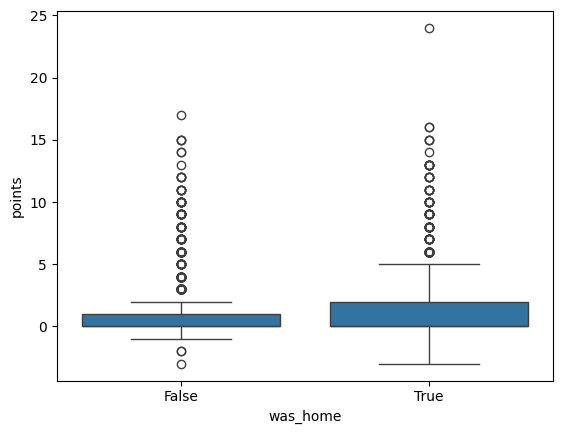

In [12]:
sns.boxplot(data=df,x='was_home',y='points')

It seems like there is some influence on the standard deviation of points gained based on whether the players play at home or not.

## Creativity Statistic

0.44318914310573526


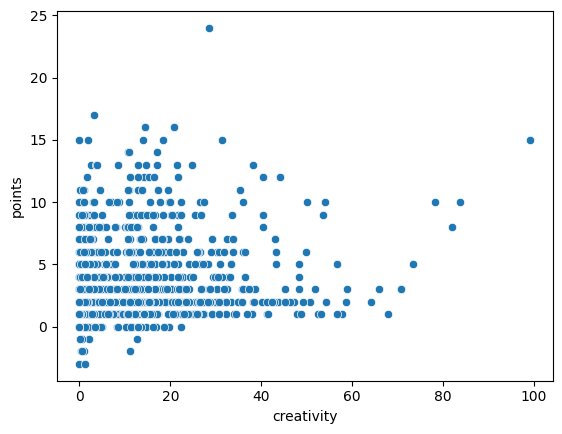

In [13]:
sns.scatterplot(data = df, x = 'creativity', y = 'points')
correlation = final_df['creativity'].corr(final_df['points'])
print(correlation)

There is a moderate correlation between the creativity statistic given by the premier league and points received.

## Affect of Team form

0.15415734575915047


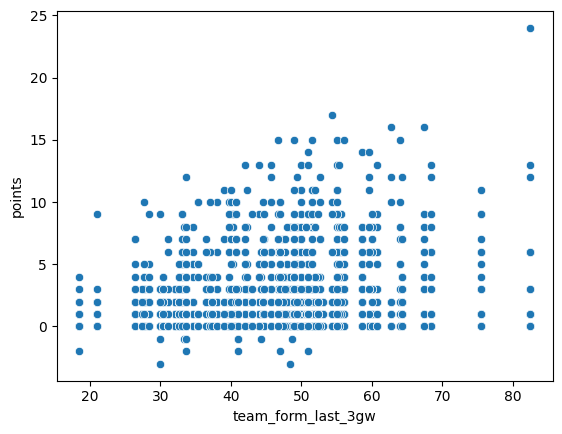

In [14]:
sns.scatterplot(data=df,x='team_form_last_3gw',y='points')
correlation = final_df['team_form_last_3gw'].corr(final_df['points'])
print(correlation)

There is a small amount of correlation between team form and points received.

## Evaluating Crowd Knowledge

0.13650150290495414


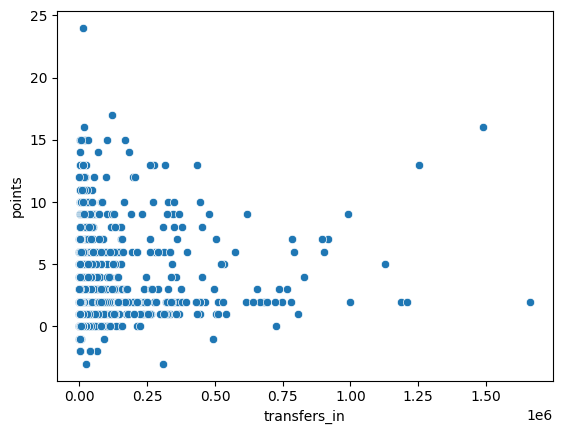

In [ ]:
sns.scatterplot(data=df,x='transfers_balance',y='points')
correlation = df['transfers_balance'].corr(df['points'])
print(correlation)

There is a moderate positive relationship between the players being transferred into clubs and the points that they receive.

# Modeling

## Model for goalkeepers

In [ ]:
goal_keeper_df = df[df['position'] == 'GK']
player_name = goal_keeper_df['player_name']
x = goal_keeper_df[['was_home','ict_per_90','points_last_3gw','minutes_last_3gw','xgi_last_3gw','clean_sheets_last3gw','bonus_last_3gw','team_form_last3gw','fixture_difficulty','stength_overall_home_player_team','stength_overall_away_player_team','stength_attack_home_player_team','stength_attack_away_player_team','stength_defence_home_opponent','strength_defence_away_opponent']]